<a href="https://colab.research.google.com/github/brainopensource/datascience-mvp/blob/ml-analytics-mvp/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Machine Learning & Analytics para conclusão da Sprint da Pós-Graduação em Ciência de Dados e Analytics (PUC Rio)

# Aluno Lucas da S. Rocha

## Introdução

Este notebook apresenta o desenvolvimento de um Mínimo Produto Viável (MVP) como parte do segundo módulo da Pós-Graduação em Ciência de Dados e Analytics da PUC-Rio. Utilizando dados abertos recentes sobre a produção de petróleo e gás no Brasil, disponibilizados pela Agência Nacional de Petróleo (ANP).

## Definição do Problema

O petróleo continua sendo um ativo estratégico no cenário energético global, afetado por fatores geopolíticos e pela volatilidade dos mercados internacionais. Nesse cenário, o Brasil se destaca como um dos principais produtores mundiais de petróleo e gás natural, tornando sua produção um tema relevante para análises e tomadas de decisão.

O objetivo deste trabalho é investigar a produção de petróleo e gás natural por poço, utilizando dados que abrangem o período de janeiro de 2020 até o primeiro semestre de 2024. Esse recorte captura as tendências mais recentes da indústria e nos permite explorar os fatores que influenciam a produtividade e a eficiência. A partir da aplicação de técnicas de ciência de dados, buscamos identificar padrões produtivos, anomalias e insights que possam otimizar a alocação de recursos e aumentar a eficiência e previsibilidade operacional e financeira.

A riqueza dos dados por poço oferece oportunidades significativas para análises detalhadas. Através de métodos estatísticos e, futuramente, de algoritmos de aprendizado de máquina, pretendemos explorar diversas aplicações, incluindo:    Análise de Eficiência da Produção, Geração de Curvas de Decaimento de Poços,    Classificação de Poços por Eficiência, Previsão da Produção Total por Campo e   Previsão de Royalties.

Essas análises iniciais geram insights valiosos para a gestão e a operação de poços e campos. O pré-processamento dos dados e a análise exploratória formam a base necessária para futuras implementações de machine learning, facilitando o desenvolvimento de modelos preditivos robustos e a criação de ferramentas analíticas que forneçam uma visão mais profunda das dinâmicas de produção. Isso permitirá, no futuro, decisões mais assertivas e embasadas no contexto da produção de petróleo e gás natural no Brasil, à medida que utilizaremos técnicas de aprendizado supervisionado em nosso estudo.


## Código do MVP

### Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import hashlib
import warnings
import missingno as msno
import re

### Funções auxiliares

  Funções que serão úteis posteriormente no nosso MVP

In [2]:
# oi

### Configuração do Ambiente

Configurações estéticas do pandas para limitar o máximo de linhas, colunas e filtrar avisos.

In [3]:
# Definindo o limite de exibição colunas de dataframe para None (sem limite)
pd.set_option('display.max_columns', 48)

# Definindo o limite de exibição de linhas de dataframe para 48
pd.set_option('display.max_rows', 48)

# Filter warnings
warnings.filterwarnings('ignore')

### Criando lista de URLs de datasets

Conforme sugerido, os dados foram disponibilizados publicamente no repositório do Github e lidos no formato Raw

[Link do Repositório](https://github.com/brainopensource/datascience-mvp)


In [5]:
url = "https://raw.githubusercontent.com/brainopensource/datascience-mvp/refs/heads/ml-analytics-mvp/datasets/monthly_production_concat/1980_2024_BR_production_data.parquet"
df_prod = pd.read_parquet(url)
display(df_prod)

,estado,bacia,nome_poco_anp,campo,periodo,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,tempo_producao_hspormes,ano,mes
0,Rio de Janeiro,Campos,3-RJS-159-RJS,PAMPO,2011-01-01,0.293000,0.0,0.293000,0.287652,0.0,0.287652,0.125568,0,2011,1
1,Rio de Janeiro,Campos,7-PM-17D-RJS,PAMPO,2011-01-01,0.196663,0.0,0.196663,0.108893,0.0,0.108893,0.012550,0,2011,1
2,Rio de Janeiro,Campos,6-BRSA-806-RJS,CARATINGA,2011-01-01,13.362645,0.0,13.362645,7.112691,0.0,7.112691,0.033568,0,2011,1
3,Rio de Janeiro,Campos,4-RJS-265A-RJS,TRILHA,2011-01-01,0.241780,0.0,0.241780,0.177410,0.0,0.177410,0.004931,0,2011,1
4,São Paulo,Santos,1-BRSA-594-SPS,SAPINHOÁ,2011-01-01,17.756235,0.0,17.756235,19.470869,0.0,19.470869,0.000000,0,2011,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476707,Espírito Santo,Campos,7-OST-6H-ESS,OSTRA,2024-06-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0,2024,6
476708,Espírito Santo,Campos,7-OST-7H-ESS,OSTRA,2024-06-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0,2024,6
476709,Espírito Santo,Campos,7-OST-3H-ESS,OSTRA,2024-06-01,2.115484,0.0,2.115484,0.428597,0.0,0.428597,12.502358,554,2024,6
476710,Espírito Santo,Campos,7-OST-1H-ESS,OSTRA,2024-06-01,1.685027,0.0,1.685027,0.535491,0.0,0.535491,14.169057,556,2024,6


### Transformações de dado

In [7]:
print(df_prod.dtypes)

# Exibir o resultado
print('before', df_prod.columns)

# Substituir acentos e espaços por underscore usando apenas regex
#df_prod.columns = [re.sub(r'[^\w]', '_', col) for col in df_prod.columns]

# Filtrando o DataFrame para o campo MERO
df_campo = df_prod[df_prod['campo'] == 'TUPI']

# Obtendo o valor mínimo e máximo de uma coluna específica, por exemplo 'periodo'
min_periodo = df_campo['periodo'].min()
max_periodo = df_campo['periodo'].max()

# Exibindo os valores
print(f"Período mínimo: {min_periodo}")
print(f"Período máximo: {max_periodo}")

display(df_campo.sort_values(by='periodo'))

estado                              object
bacia                               object
nome_poco_anp                       object
campo                               object
periodo                     datetime64[ns]
oleo_kbd                           float64
condensado_kbd                     float64
petroleo_kbd                       float64
gas_natural_mmscf_assoc            float64
gas_natural_mmscf_nassoc           float64
gas_natural_mmscf_total            float64
agua_kbd                           float64
tempo_producao_hspormes              int64
ano                                  int32
mes                                  int32
dtype: object
before Index(['estado', 'bacia', 'nome_poco_anp', 'campo', 'periodo', 'oleo_kbd',
       'condensado_kbd', 'petroleo_kbd', 'gas_natural_mmscf_assoc',
       'gas_natural_mmscf_nassoc', 'gas_natural_mmscf_total', 'agua_kbd',
       'tempo_producao_hspormes', 'ano', 'mes'],
      dtype='object')
Período mínimo: 2009-04-01 00:00:00
Período má

,estado,bacia,nome_poco_anp,campo,periodo,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,tempo_producao_hspormes,ano,mes
286574,Rio de Janeiro,Santos,3-BRSA-496-RJS,TUPI,2009-04-01,1.464677,0.0,1.464677,1.941115,0.0,1.941115,0.029887,0,2009,4
287272,Rio de Janeiro,Santos,3-BRSA-496-RJS,TUPI,2009-05-01,0.770400,0.0,0.770400,1.068577,0.0,1.068577,0.005655,0,2009,5
288491,Rio de Janeiro,Santos,3-BRSA-496-RJS,TUPI,2009-06-01,13.793688,0.0,13.793688,20.373107,0.0,20.373107,0.000000,0,2009,6
289356,Rio de Janeiro,Santos,3-BRSA-496-RJS,TUPI,2009-07-01,1.046452,0.0,1.046452,1.529314,0.0,1.529314,0.000000,0,2009,7
290695,Rio de Janeiro,Santos,3-BRSA-496-RJS,TUPI,2009-09-01,16.316333,0.0,16.316333,20.579009,0.0,20.579009,0.000000,0,2009,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27022,Rio de Janeiro,Santos,9-LL-12D-RJS,TUPI,2024-06-01,23.542357,0.0,23.542357,35.169009,0.0,35.169009,0.738570,648,2024,6
27021,Rio de Janeiro,Santos,7-SLL-5-RJS,TUPI,2024-06-01,19.947207,0.0,19.947207,36.235238,0.0,36.235238,0.038028,659,2024,6
27019,Rio de Janeiro,Santos,3-BRSA-883-RJS,TUPI,2024-06-01,2.648505,0.0,2.648505,11.240090,0.0,11.240090,0.409626,166,2024,6
27029,Rio de Janeiro,Santos,7-LL-119D-RJS,TUPI,2024-06-01,19.698111,0.0,19.698111,37.958479,0.0,37.958479,0.312818,634,2024,6


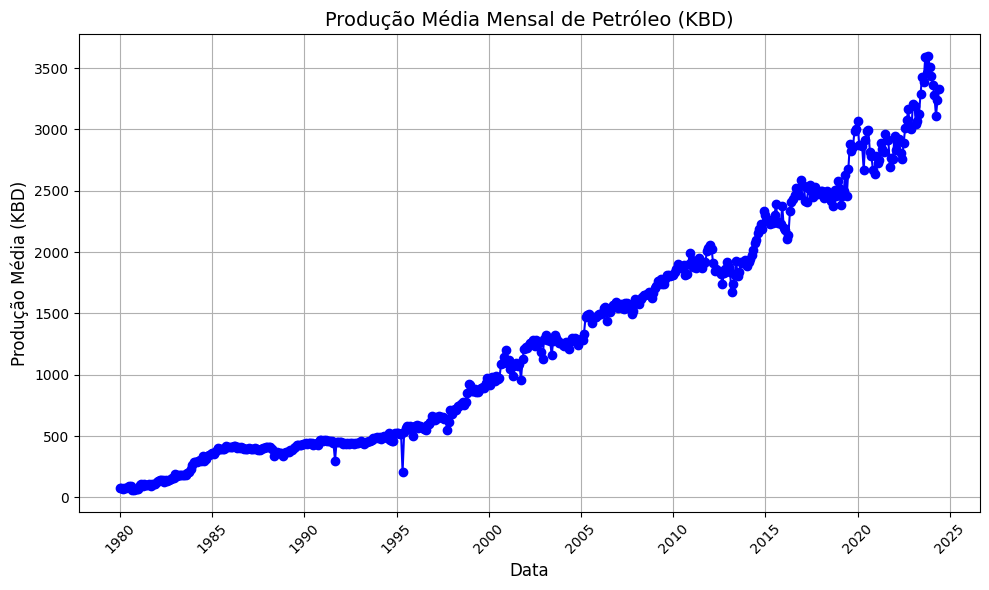

In [8]:
# Certifique-se de que a coluna 'periodo' está em formato datetime
#df_prod['periodo'] = pd.to_datetime(df_prod['periodo'], format='%Y-%m-%d')

# Agrupar por ano e mês, somando a produção média diária em KBD (mil barris por dia)
df_grouped = df_prod.groupby(df_prod['periodo'].dt.to_period('M')).agg(producao_media_kbd=('petroleo_kbd', 'sum')).reset_index()

# Convertendo a coluna 'periodo' de volta para datetime (primeiro dia do mês) para fins de plotagem
df_grouped['periodo'] = df_grouped['periodo'].dt.to_timestamp()

# Plotar o gráfico da produção média em KBD ao longo dos meses
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['periodo'], df_grouped['producao_media_kbd'], marker='o', linestyle='-', color='b')

# Adicionar títulos e labels
plt.title('Produção Média Mensal de Petróleo (KBD)', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Produção Média (KBD)', fontsize=12)

# Exibir o gráfico
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Curvas Acumuladas

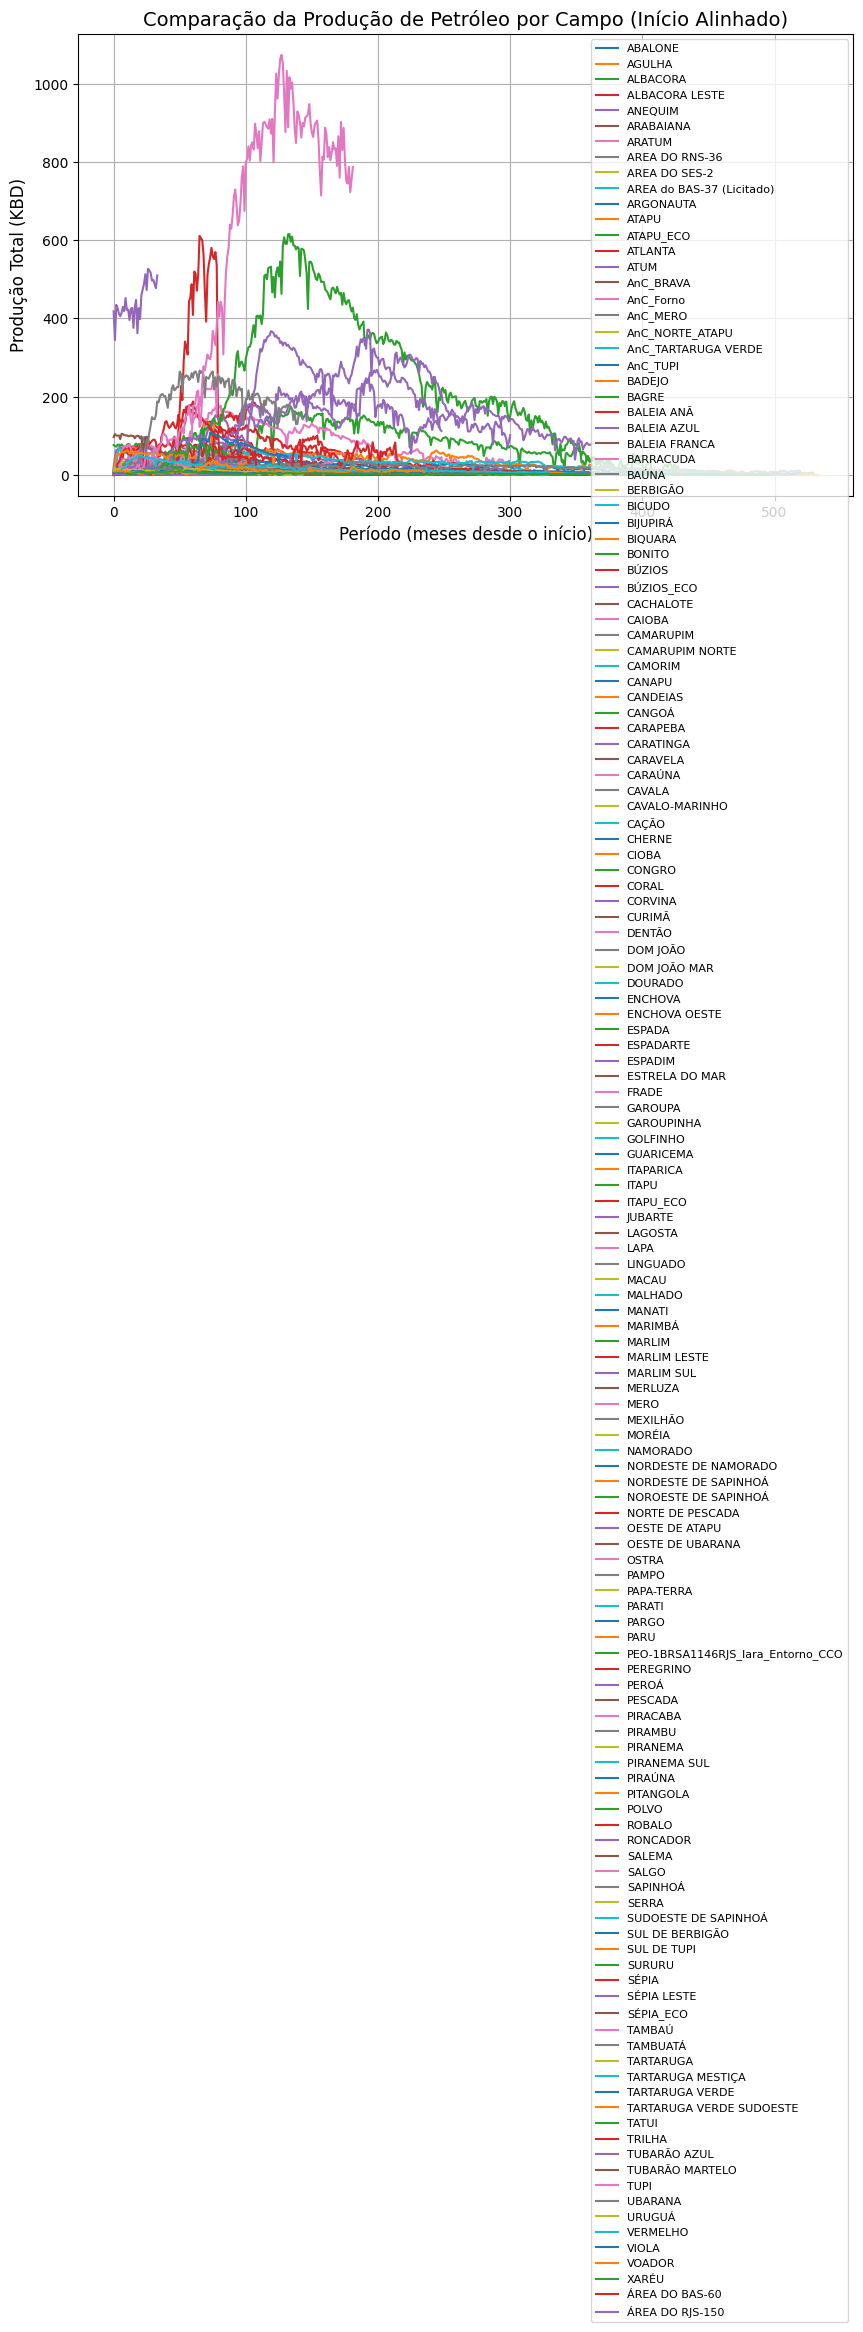

In [9]:
# Agrupar por campo e obter a produção total por mês
df_grouped = df_prod.groupby(['campo', df_prod['periodo'].dt.to_period('M')]).agg(producao_total_kbd=('petroleo_kbd', 'sum')).reset_index()

# Dicionário para armazenar a produção de cada campo, redefinindo o tempo (X=0 para todos)
campos_producao = {}

# Iterar sobre cada campo e redefinir o tempo (indexar a partir de 0)
for campo in df_grouped['campo'].unique():
    campo_df = df_grouped[df_grouped['campo'] == campo]
    campo_df = campo_df.reset_index(drop=True)
    campos_producao[campo] = campo_df['producao_total_kbd'].values

# Plotar todos os campos, começando de X=0
plt.figure(figsize=(10, 6))

for campo, producao in campos_producao.items():
    plt.plot(range(len(producao)), producao, label=campo)

# Adicionar título e labels
plt.title('Comparação da Produção de Petróleo por Campo (Início Alinhado)', fontsize=14)
plt.xlabel('Período (meses desde o início)', fontsize=12)
plt.ylabel('Produção Total (KBD)', fontsize=12)

# Adicionar legenda
plt.legend(loc='upper right', fontsize=8)

# Exibir o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()


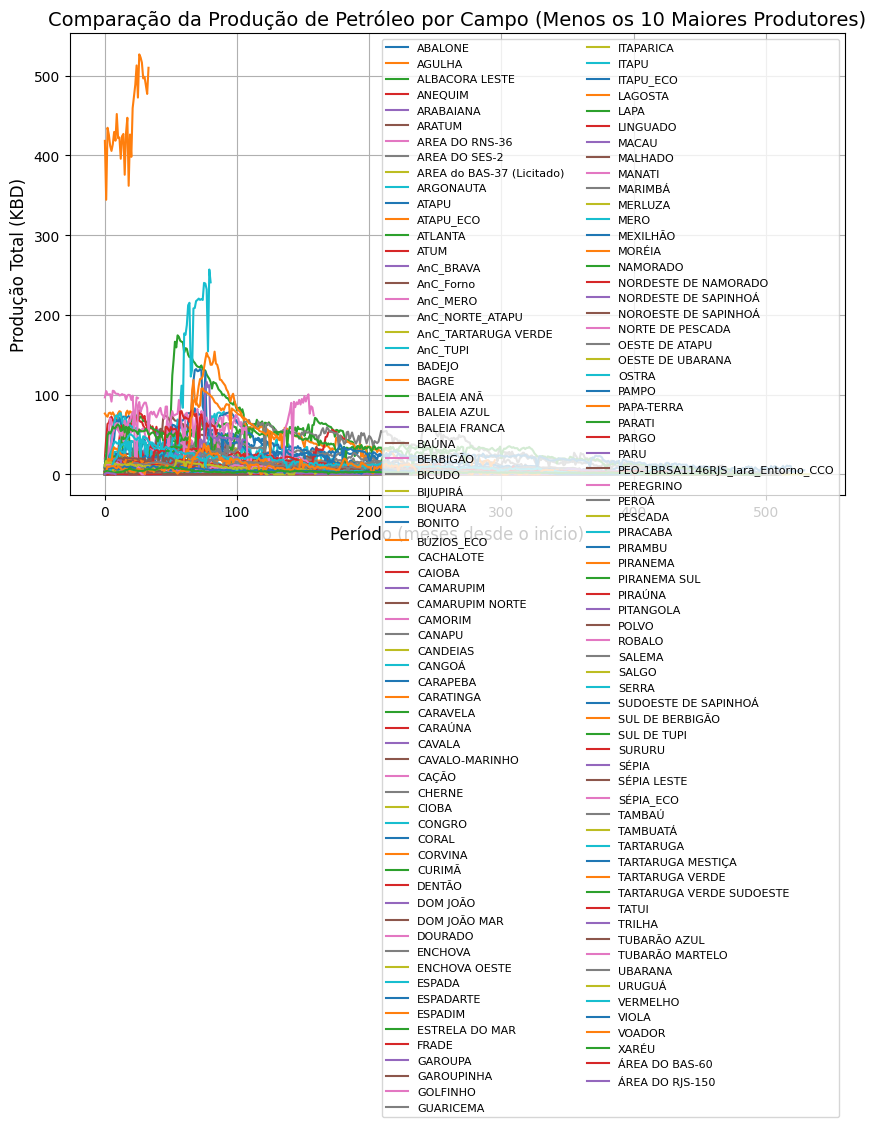

In [10]:
# Agrupar por campo para calcular a produção total de cada campo
producao_total_por_campo = df_prod.groupby('campo')['petroleo_kbd'].sum().sort_values(ascending=False)

# Obter os 10 maiores produtores
maiores_produtores = producao_total_por_campo.head(10).index

# Filtrar os dados removendo os 10 maiores produtores
df_filtrado = df_prod[~df_prod['campo'].isin(maiores_produtores)]

# Agrupar por campo e obter a produção total por mês para os campos restantes
df_grouped = df_filtrado.groupby(['campo', df_filtrado['periodo'].dt.to_period('M')]).agg(producao_total_kbd=('petroleo_kbd', 'sum')).reset_index()

# Dicionário para armazenar a produção de cada campo, redefinindo o tempo (X=0 para todos)
campos_producao = {}

# Iterar sobre cada campo e redefinir o tempo (indexar a partir de 0)
for campo in df_grouped['campo'].unique():
    campo_df = df_grouped[df_grouped['campo'] == campo]
    campo_df = campo_df.reset_index(drop=True)
    campos_producao[campo] = campo_df['producao_total_kbd'].values

# Plotar todos os campos, começando de X=0 (exceto os 10 maiores produtores)
plt.figure(figsize=(10, 6))

for campo, producao in campos_producao.items():
    plt.plot(range(len(producao)), producao, label=campo)

# Adicionar título e labels
plt.title('Comparação da Produção de Petróleo por Campo (Menos os 10 Maiores Produtores)', fontsize=14)
plt.xlabel('Período (meses desde o início)', fontsize=12)
plt.ylabel('Produção Total (KBD)', fontsize=12)

# Adicionar legenda
plt.legend(loc='upper right', fontsize=8, ncol=2)  # ncol ajusta o número de colunas na legenda

# Exibir o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()


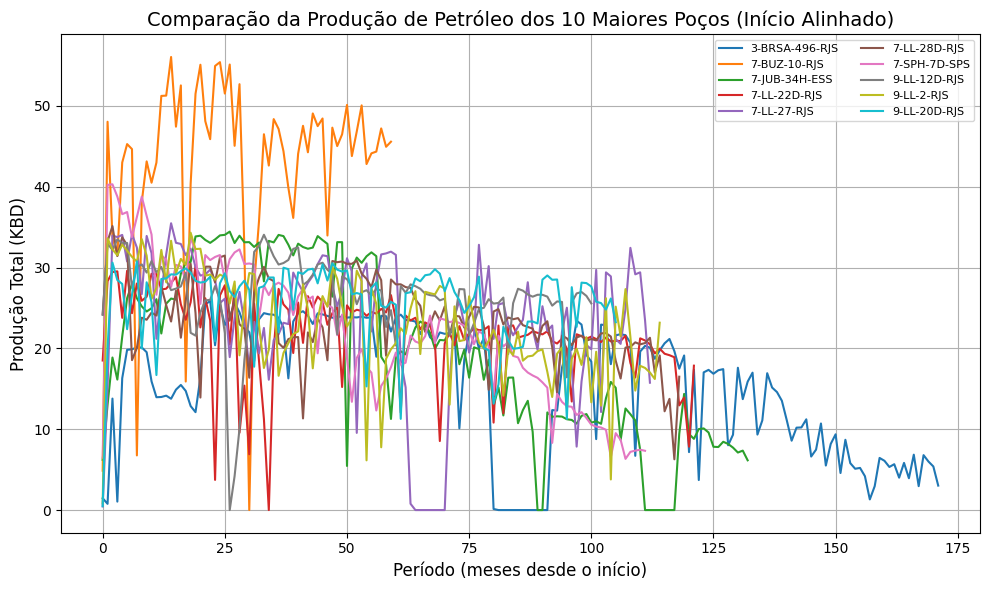

In [11]:
# Agrupar por poço para calcular a produção total de cada poço
producao_total_por_poco = df_prod.groupby('nome_poco_anp')['petroleo_kbd'].sum().sort_values(ascending=False)

# Obter os 10 maiores poços produtores
maiores_pocos = producao_total_por_poco.head(10).index

# Filtrar os dados para apenas os 10 maiores poços
df_filtrado = df_prod[df_prod['nome_poco_anp'].isin(maiores_pocos)]

# Agrupar por poço e período para obter a produção total por mês dos 10 maiores poços
df_grouped = df_filtrado.groupby(['nome_poco_anp', df_filtrado['periodo'].dt.to_period('M')]).agg(producao_total_kbd=('petroleo_kbd', 'sum')).reset_index()

# Dicionário para armazenar a produção de cada poço, redefinindo o tempo (X=0 para todos)
pocos_producao = {}

# Iterar sobre cada poço e redefinir o tempo (indexar a partir de 0)
for poco in df_grouped['nome_poco_anp'].unique():
    poco_df = df_grouped[df_grouped['nome_poco_anp'] == poco]
    poco_df = poco_df.reset_index(drop=True)
    pocos_producao[poco] = poco_df['producao_total_kbd'].values

# Plotar os 10 maiores poços, começando de X=0
plt.figure(figsize=(10, 6))

for poco, producao in pocos_producao.items():
    plt.plot(range(len(producao)), producao, label=poco)

# Adicionar título e labels
plt.title('Comparação da Produção de Petróleo dos 10 Maiores Poços (Início Alinhado)', fontsize=14)
plt.xlabel('Período (meses desde o início)', fontsize=12)
plt.ylabel('Produção Total (KBD)', fontsize=12)

# Adicionar legenda
plt.legend(loc='upper right', fontsize=8, ncol=2)  # ncol ajusta o número de colunas na legenda

# Exibir o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
print(df_prod.dtypes)

estado                              object
bacia                               object
nome_poco_anp                       object
campo                               object
periodo                     datetime64[ns]
oleo_kbd                           float64
condensado_kbd                     float64
petroleo_kbd                       float64
gas_natural_mmscf_assoc            float64
gas_natural_mmscf_nassoc           float64
gas_natural_mmscf_total            float64
agua_kbd                           float64
tempo_producao_hspormes              int64
ano                                  int32
mes                                  int32
dias_no_mes                          int32
producao_total_mes                 float64
producao_acumulada                 float64
dtype: object


In [12]:
# Calcular o número de dias no mês
df_prod['dias_no_mes'] = df_prod['periodo'].dt.days_in_month

# Calcular a produção total no mês (média diária * número de dias no mês)
df_prod['producao_total_mes'] = df_prod['petroleo_kbd'] * df_prod['dias_no_mes']

# Agora, agrupar por poço e calcular a produção acumulada ao longo do tempo
df_prod['producao_acumulada'] = df_prod.groupby('nome_poco_anp')['producao_total_mes'].cumsum()

In [15]:
# Definindo a nova ordem das colunas
colunas_ordenadas = [
    'periodo', 'nome_poco_anp', 'oleo_kbd', 'condensado_kbd', 'petroleo_kbd',
    'gas_natural_mmscf_assoc', 'gas_natural_mmscf_nassoc', 'gas_natural_mmscf_total',
    'agua_kbd', 'estado', 'bacia', 'campo', 'tempo_producao_hspormes', 'ano', 'mes', 'dias_no_mes',
    'producao_total_mes', 'producao_acumulada'
    ]

# Reorganizando as colunas do DataFrame
df_prod = df_prod[colunas_ordenadas]

# Verificando a nova ordem das colunas
df_prod.sort_values(by='periodo').head(5)

,periodo,nome_poco_anp,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,estado,bacia,campo,tempo_producao_hspormes,ano,mes,dias_no_mes,producao_total_mes,producao_acumulada
27225,1980-01-01,7-DJ-467-BA,0.015745,0.0,0.015745,0.001554,0.0,0.001554,0.076857,Bahia,Recôncavo,DOM JOÃO MAR,0,1980,1,31,0.488089,0.488089
27340,1980-01-01,7-DJ-295-BA,0.012681,0.0,0.012681,0.009168,0.0,0.009168,0.003003,Bahia,Recôncavo,DOM JOÃO MAR,0,1980,1,31,0.393114,0.393114
27339,1980-01-01,7-DJ-293-BA,0.025910,0.0,0.025910,0.004181,0.0,0.004181,0.048046,Bahia,Recôncavo,DOM JOÃO MAR,0,1980,1,31,0.803210,0.803210
27338,1980-01-01,7-DJ-292-BA,0.041472,0.0,0.041472,0.003715,0.0,0.003715,0.026579,Bahia,Recôncavo,DOM JOÃO MAR,0,1980,1,31,1.285638,1.285638
27337,1980-01-01,7-DJ-285-BA,0.057643,0.0,0.057643,0.007391,0.0,0.007391,0.204419,Bahia,Recôncavo,DOM JOÃO MAR,0,1980,1,31,1.786936,1.786936


In [25]:
# Número de atributos (colunas) e instâncias (linhas)
num_atributos = df_prod.shape[1]
num_instancias = df_prod.shape[0]

# Tipos de dados dos atributos
tipos_dados = df_prod.dtypes

# Contagem de valores faltantes por coluna
valores_faltantes = df_prod.isnull().sum()

# Resumo estatístico dos dados numéricos
resumo_estatistico = df_prod.describe()

# Printando os resultados com f-strings
print(f"Número de atributos: {num_atributos}")
print(f"Número de instâncias: {num_instancias}")
display(f"Tipos de dados dos atributos", tipos_dados)

display(f"Valores faltantes por coluna", valores_faltantes)
display(f"Resumo estatístico dos atributos numéricos", resumo_estatistico)

Número de atributos: 18
Número de instâncias: 449640


'Tipos de dados dos atributos'

,0
periodo,datetime64[ns]
nome_poco_anp,object
oleo_kbd,float64
condensado_kbd,float64
petroleo_kbd,float64
gas_natural_mmscf_assoc,float64
gas_natural_mmscf_nassoc,float64
gas_natural_mmscf_total,float64
agua_kbd,float64
estado,object


'Valores faltantes por coluna'

,0
periodo,0
nome_poco_anp,0
oleo_kbd,0
condensado_kbd,0
petroleo_kbd,0
gas_natural_mmscf_assoc,0
gas_natural_mmscf_nassoc,0
gas_natural_mmscf_total,0
agua_kbd,0
estado,0


'Resumo estatístico dos atributos numéricos'

,periodo,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,tempo_producao_hspormes,ano,mes,dias_no_mes,producao_total_mes,producao_acumulada
count,449640,449640.000000,449640.000000,449640.000000,449640.000000,449640.000000,449640.000000,449640.000000,449640.000000,449640.00000,449640.000000,449640.000000,449640.000000,449640.000000
mean,2005-01-02 08:38:09.127302016,1.535746,0.005117,1.540864,1.342017,0.258278,1.600295,0.914346,118.226250,2004.54996,6.480438,30.440330,46.900128,6364.348447
min,1980-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000006,0.000000,1980.00000,1.000000,28.000000,0.000000,0.000000
25%,1994-07-01 00:00:00,0.010252,0.000000,0.013107,0.000819,0.000000,0.001737,0.000000,0.000000,1994.00000,3.000000,30.000000,0.398773,347.661408
50%,2005-10-01 00:00:00,0.173096,0.000000,0.183542,0.096640,0.000000,0.119210,0.030617,0.000000,2005.00000,6.000000,31.000000,5.588009,1911.292911
75%,2016-12-01 00:00:00,1.138815,0.000000,1.145483,0.734427,0.000000,0.856765,0.595751,1.000000,2016.00000,9.000000,31.000000,34.871152,7492.176657
max,2024-06-01 00:00:00,56.094150,7.160454,56.094150,223.659765,73.709100,223.659765,56.772525,757.000000,2024.00000,12.000000,31.000000,1738.918662,85983.739844
std,NaN,3.815505,0.064234,3.813990,5.023357,2.675724,5.630319,2.404325,248.389658,12.56670,3.451803,0.810454,116.137954,10433.258487


## Curvas Acumuladas

In [26]:
# Encontrar os 5 maiores produtores
maiores_produtores = df_prod.groupby('campo')['oleo_kbd'].sum().nlargest(10).index.tolist()

# Criar um DataFrame para a produção acumulada
df_acumulado = pd.DataFrame()

for campo in maiores_produtores:
    # Filtrar dados para o campo atual
    df_campo = df_prod[df_prod['campo'] == campo]

    # Agrupar por período e somar a produção
    producoes_diarias = df_campo.groupby(df_campo['periodo'].dt.date)['oleo_kbd'].sum()

    # Calcular a produção acumulada
    producoes_acumuladas = producoes_diarias.cumsum() / 1000  # Convertendo para milhares de barris

    # Adicionar ao DataFrame
    df_acumulado[campo] = producoes_acumuladas

# Convertendo o índice para datetime, caso não esteja no formato correto
df_acumulado.index = pd.to_datetime(df_acumulado.index)

# Agora, filtrar apenas o primeiro mês de cada ano
df_acumulado_ano = df_acumulado[df_acumulado.index.month == 1]

# Filtrar para remover 2015 e 2016
df_acumulado_ano = df_acumulado_ano[df_acumulado_ano.index.year >= 1980]

# Garantir que o índice esteja no formato datetime
df_acumulado.index = pd.to_datetime(df_acumulado.index)

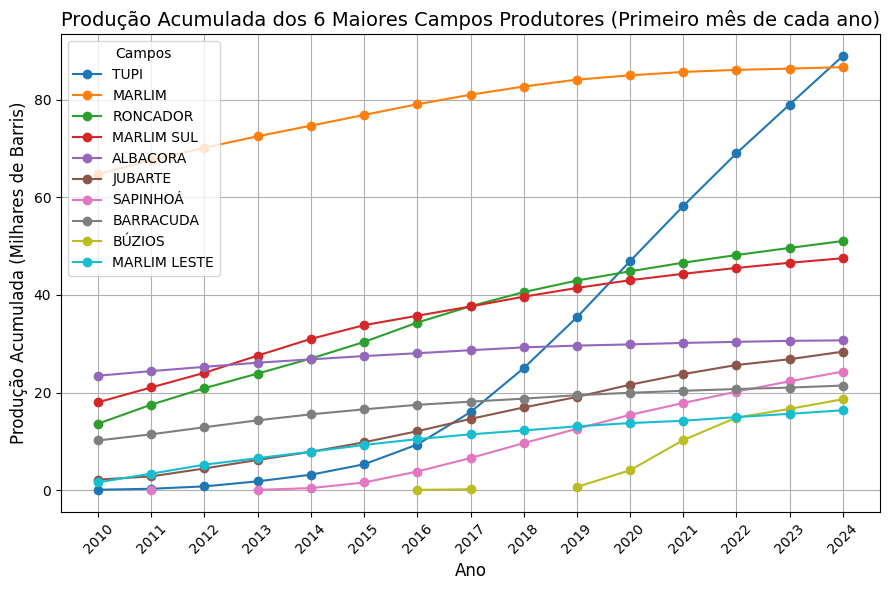

In [27]:
# Criar gráfico de linhas para a produção acumulada
plt.figure(figsize=(9, 6))

# Plotar cada linha para os 5 maiores produtores
for campo in maiores_produtores:
    plt.plot(df_acumulado_ano.index, df_acumulado_ano[campo], label=campo, marker='o')

# Configurações do gráfico
plt.title('Produção Acumulada dos 6 Maiores Campos Produtores (Primeiro mês de cada ano)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Produção Acumulada (Milhares de Barris)', fontsize=12)

# Ajustar o eixo X para mostrar as datas corretamente
plt.xticks(ticks=df_acumulado_ano.index, labels=df_acumulado_ano.index.year, rotation=45)

# Adicionar grade e legenda
plt.grid(True)
plt.legend(title='Campos', loc='upper left')

# Ajustar layout para não cortar a legenda
plt.tight_layout()

# Exibir o gráfico
plt.show()


In [28]:
display(df_acumulado_ano)
print(df_acumulado_ano.dtypes)

,TUPI,MARLIM,RONCADOR,MARLIM SUL,ALBACORA,JUBARTE,SAPINHOÁ,BARRACUDA,BÚZIOS,MARLIM LESTE
periodo,,,,,,,,,,
2010-01-01,0.113348,64.712317,13.646791,18.032666,23.472950,2.185588,NaN,10.202416,NaN,1.633473
2011-01-01,0.313619,67.617237,17.547340,21.073375,24.405636,2.850113,0.020902,11.473313,NaN,3.406047
2012-01-01,0.799720,70.160781,20.907831,24.062815,25.284517,4.467898,NaN,12.910556,NaN,5.246292
2013-01-01,1.836980,72.516977,23.915528,27.590077,26.135754,6.227034,0.090297,14.333197,NaN,6.588655
2014-01-01,3.195057,74.676556,26.979633,31.013944,26.821396,7.880273,0.450403,15.557816,NaN,7.893631
2015-01-01,5.320382,76.883279,30.379833,33.821690,27.493470,9.831337,1.595958,16.582364,NaN,9.291824
2016-01-01,9.367112,79.058824,34.345557,35.743870,28.070779,12.098265,3.842153,17.504785,0.084371,10.478812
2017-01-01,16.015496,81.021107,37.697302,37.650088,28.692093,14.621675,6.605899,18.155496,0.210234,11.459765
2018-01-01,25.011322,82.698088,40.590511,39.651099,29.270801,16.961337,9.658506,18.766911,NaN,12.260059


TUPI            float64
MARLIM          float64
RONCADOR        float64
MARLIM SUL      float64
ALBACORA        float64
JUBARTE         float64
SAPINHOÁ        float64
BARRACUDA       float64
BÚZIOS          float64
MARLIM LESTE    float64
dtype: object


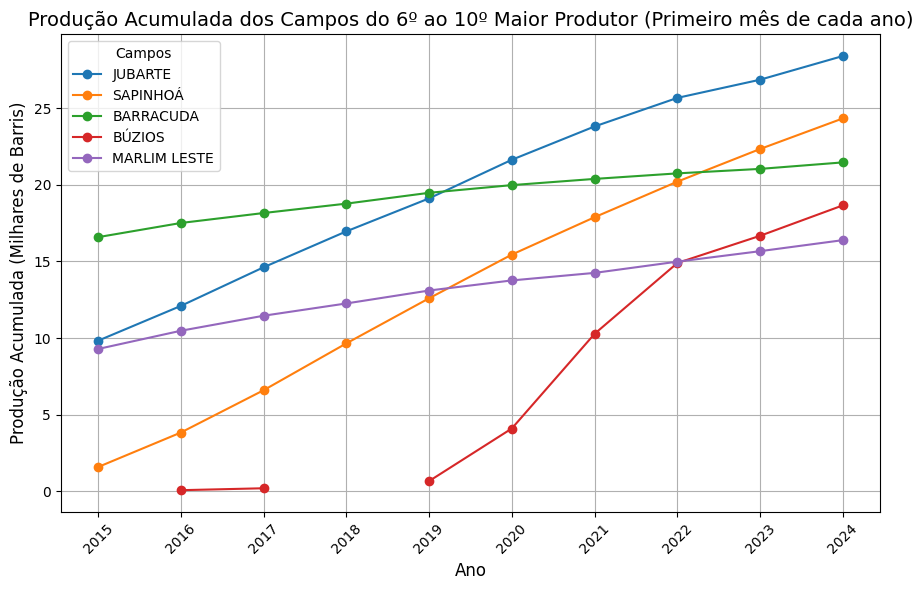

In [29]:
# Encontrar os 10 maiores produtores (do 1º ao 10º)
maiores_produtores = df_prod.groupby('campo')['oleo_kbd'].sum().nlargest(10).index.tolist()

# Selecionar os produtores do 6º ao 10º lugar
campos_5_ao_10 = maiores_produtores[5:10]  # Pega os campos da posição 6 à 10

# Criar um DataFrame para a produção acumulada
df_acumulado = pd.DataFrame()

# Filtrar e agrupar os dados para os campos selecionados
for campo in campos_5_ao_10:
    # Filtrar dados para o campo atual
    df_campo = df_prod[df_prod['campo'] == campo]

    # Agrupar por período e somar a produção
    producoes_diarias = df_campo.groupby(df_campo['periodo'].dt.date)['oleo_kbd'].sum()

    # Calcular a produção acumulada
    producoes_acumuladas = producoes_diarias.cumsum() / 1000  # Convertendo para milhares de barris

    # Adicionar ao DataFrame
    df_acumulado[campo] = producoes_acumuladas

# Convertendo o índice para datetime, caso não esteja no formato correto
df_acumulado.index = pd.to_datetime(df_acumulado.index)

# Agora, filtrar apenas o primeiro mês de cada ano
df_acumulado_ano = df_acumulado[df_acumulado.index.month == 1]

# Filtrar para remover 2015 e 2016
df_acumulado_ano = df_acumulado_ano[df_acumulado_ano.index.year >= 2015]

# Criar gráfico de linhas para a produção acumulada
plt.figure(figsize=(9, 6))

# Plotar cada linha para os campos de 5º a 10º maior produtor
for campo in campos_5_ao_10:
    plt.plot(df_acumulado_ano.index, df_acumulado_ano[campo], label=campo, marker='o')

# Configurações do gráfico
plt.title('Produção Acumulada dos Campos do 6º ao 10º Maior Produtor (Primeiro mês de cada ano)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Produção Acumulada (Milhares de Barris)', fontsize=12)

# Ajustar o eixo X para mostrar os anos corretamente
plt.xticks(ticks=df_acumulado_ano.index, labels=df_acumulado_ano.index.year, rotation=45)

# Adicionar grade e legenda
plt.grid(True)
plt.legend(title='Campos', loc='upper left')

# Ajustar layout para não cortar a legenda
plt.tight_layout()

# Exibir o gráfico
plt.show()


In [30]:
display(df_acumulado)
display(df_prod)

,JUBARTE,SAPINHOÁ,BARRACUDA,BÚZIOS,MARLIM LESTE
periodo,,,,,
2002-10-01,0.003581,NaN,1.696906,NaN,NaN
2002-11-01,0.018867,NaN,1.696906,NaN,NaN
2002-12-01,0.033381,NaN,1.696906,NaN,NaN
2003-01-01,0.051441,NaN,1.696906,NaN,NaN
2003-02-01,0.068570,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-02-01,28.527099,24.450493,21.489760,18.827603,16.420729
2024-03-01,28.656062,24.603783,21.516872,19.003903,NaN
2024-04-01,28.788352,24.758580,21.549880,19.176448,NaN


,periodo,nome_poco_anp,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,estado,bacia,campo,tempo_producao_hspormes,ano,mes,dias_no_mes,producao_total_mes,producao_acumulada
0,2011-01-01,3-RJS-159-RJS,0.293000,0.0,0.293000,0.287652,0.0,0.287652,0.125568,Rio de Janeiro,Campos,PAMPO,0,2011,1,31,9.083000,9.083000
1,2011-01-01,7-PM-17D-RJS,0.196663,0.0,0.196663,0.108893,0.0,0.108893,0.012550,Rio de Janeiro,Campos,PAMPO,0,2011,1,31,6.096562,6.096562
2,2011-01-01,6-BRSA-806-RJS,13.362645,0.0,13.362645,7.112691,0.0,7.112691,0.033568,Rio de Janeiro,Campos,CARATINGA,0,2011,1,31,414.241980,414.241980
3,2011-01-01,4-RJS-265A-RJS,0.241780,0.0,0.241780,0.177410,0.0,0.177410,0.004931,Rio de Janeiro,Campos,TRILHA,0,2011,1,31,7.495177,7.495177
4,2011-01-01,1-BRSA-594-SPS,17.756235,0.0,17.756235,19.470869,0.0,19.470869,0.000000,São Paulo,Santos,SAPINHOÁ,0,2011,1,31,550.443288,550.443288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476707,2024-06-01,7-OST-6H-ESS,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,Espírito Santo,Campos,OSTRA,0,2024,6,30,0.000000,17656.181326
476708,2024-06-01,7-OST-7H-ESS,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,Espírito Santo,Campos,OSTRA,0,2024,6,30,0.000000,10322.332878
476709,2024-06-01,7-OST-3H-ESS,2.115484,0.0,2.115484,0.428597,0.0,0.428597,12.502358,Espírito Santo,Campos,OSTRA,554,2024,6,30,63.464517,21717.816577
476710,2024-06-01,7-OST-1H-ESS,1.685027,0.0,1.685027,0.535491,0.0,0.535491,14.169057,Espírito Santo,Campos,OSTRA,556,2024,6,30,50.550819,16375.090354


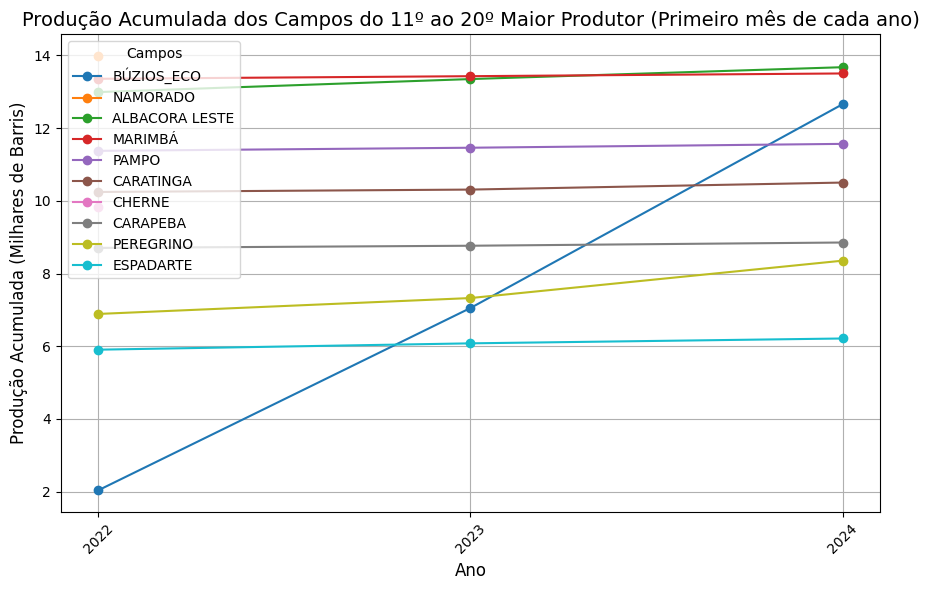

In [31]:
# Encontrar os 10 maiores produtores (do 1º ao 20º)
maiores_produtores = df_prod.groupby('campo')['oleo_kbd'].sum().nlargest(20).index.tolist()

# Selecionar os produtores do 5º ao 10º lugar
campos_10_ao_20 = maiores_produtores[10:20]  # Pega os campos da posição 10 à 20

# Criar um DataFrame para a produção acumulada
df_acumulado = pd.DataFrame()

# Filtrar e agrupar os dados para os campos selecionados
for campo in campos_10_ao_20:
    # Filtrar dados para o campo atual
    df_campo = df_prod[df_prod['campo'] == campo]

    # Agrupar por período e somar a produção
    producoes_diarias = df_campo.groupby(df_campo['periodo'].dt.date)['oleo_kbd'].sum()

    # Calcular a produção acumulada
    producoes_acumuladas = producoes_diarias.cumsum() / 1000  # Convertendo para milhares de barris

    # Adicionar ao DataFrame
    df_acumulado[campo] = producoes_acumuladas

# Convertendo o índice para datetime, caso não esteja no formato correto
df_acumulado.index = pd.to_datetime(df_acumulado.index)

# Agora, filtrar apenas o primeiro mês de cada ano
df_acumulado_ano = df_acumulado[df_acumulado.index.month == 1]

# Filtrar para remover 2015 e 2016
df_acumulado_ano = df_acumulado_ano[df_acumulado_ano.index.year >= 2015]

# Criar gráfico de linhas para a produção acumulada
plt.figure(figsize=(9, 6))

# Plotar cada linha para os campos de 5º a 10º maior produtor
for campo in campos_10_ao_20:
    plt.plot(df_acumulado_ano.index, df_acumulado_ano[campo], label=campo, marker='o')

# Configurações do gráfico
plt.title('Produção Acumulada dos Campos do 11º ao 20º Maior Produtor (Primeiro mês de cada ano)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Produção Acumulada (Milhares de Barris)', fontsize=12)

# Ajustar o eixo X para mostrar os anos corretamente
plt.xticks(ticks=df_acumulado_ano.index, labels=df_acumulado_ano.index.year, rotation=45)

# Adicionar grade e legenda
plt.grid(True)
plt.legend(title='Campos', loc='upper left')

# Ajustar layout para não cortar a legenda
plt.tight_layout()

# Exibir o gráfico
plt.show()


### MACHINE LEARNING

In [33]:
display(df_prod)

,periodo,nome_poco_anp,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,estado,bacia,campo,tempo_producao_hspormes,ano,mes,dias_no_mes,producao_total_mes,producao_acumulada
0,2011-01-01,3-RJS-159-RJS,0.293000,0.0,0.293000,0.287652,0.0,0.287652,0.125568,Rio de Janeiro,Campos,PAMPO,0,2011,1,31,9.083000,9.083000
1,2011-01-01,7-PM-17D-RJS,0.196663,0.0,0.196663,0.108893,0.0,0.108893,0.012550,Rio de Janeiro,Campos,PAMPO,0,2011,1,31,6.096562,6.096562
2,2011-01-01,6-BRSA-806-RJS,13.362645,0.0,13.362645,7.112691,0.0,7.112691,0.033568,Rio de Janeiro,Campos,CARATINGA,0,2011,1,31,414.241980,414.241980
3,2011-01-01,4-RJS-265A-RJS,0.241780,0.0,0.241780,0.177410,0.0,0.177410,0.004931,Rio de Janeiro,Campos,TRILHA,0,2011,1,31,7.495177,7.495177
4,2011-01-01,1-BRSA-594-SPS,17.756235,0.0,17.756235,19.470869,0.0,19.470869,0.000000,São Paulo,Santos,SAPINHOÁ,0,2011,1,31,550.443288,550.443288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476707,2024-06-01,7-OST-6H-ESS,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,Espírito Santo,Campos,OSTRA,0,2024,6,30,0.000000,17656.181326
476708,2024-06-01,7-OST-7H-ESS,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,Espírito Santo,Campos,OSTRA,0,2024,6,30,0.000000,10322.332878
476709,2024-06-01,7-OST-3H-ESS,2.115484,0.0,2.115484,0.428597,0.0,0.428597,12.502358,Espírito Santo,Campos,OSTRA,554,2024,6,30,63.464517,21717.816577
476710,2024-06-01,7-OST-1H-ESS,1.685027,0.0,1.685027,0.535491,0.0,0.535491,14.169057,Espírito Santo,Campos,OSTRA,556,2024,6,30,50.550819,16375.090354


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Definindo o campo de interesse
campo_especifico = 'TUPI'

# Filtrando os dados para o campo específico
campo_df = df_prod[df_prod['campo'] == campo_especifico]

# Ordenar os dados pela coluna 'periodo' (data)
campo_df_sorted = campo_df.sort_values(by='periodo')

# Definindo a data de corte para separar treino e teste
# Aqui, vou usar a última data do treino como a data de corte, você pode definir uma data específica
data_corte = campo_df_sorted['periodo'].max() - pd.DateOffset(months=6)  # Por exemplo, 3 meses antes da última data

# Separar os dados em treino e teste com base na data de corte
train_df = campo_df_sorted[campo_df_sorted['periodo'] <= data_corte]
test_df = campo_df_sorted[campo_df_sorted['periodo'] > data_corte]

# Seleção de features e target (usando apenas 'oleo_kbd' como feature)
features = ['oleo_kbd']
target = 'producao_acumulada'

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Prever a produção no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Exemplo de previsão para o próximo mês (ajustando o valor de 'oleo_kbd')
novo_mes = {'oleo_kbd': 0.85}  # Aqui você ajusta o valor de 'oleo_kbd' para o próximo mês
X_novo_mes = pd.DataFrame([novo_mes])

# Prever a produção acumulada para o próximo mês
producao_prevista = model.predict(X_novo_mes)
print(f'Produção prevista para o próximo mês: {producao_prevista[0]}')


Mean Squared Error: 747591020.1044762
Produção prevista para o próximo mês: 17626.50539087213


,periodo,nome_poco_anp,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,volume_gas_royalties_mmscf,agua_kbd,estado,bacia,campo,operador,numero_contrato,tempo_producao_hspormes,ano,mes,dias_no_mes,producao_total_mes,producao_acumulada,instalacao_destino,tipo_instalacao,nome_poco_operador,unique_index
18,2015-01-01,3-BRSA-496-RJS,23.984485,0.0,23.984485,38.940298,0.0,38.940298,457.937312,0.000000,Rio de Janeiro,Santos,TUPI,Petrobras,486100038862000,0,2015,1,31,743.519032,743.519032,FPSO CIDADE DE ANGRA DOS REIS,UEP,3RJS646,677c510ed2b10cdeec6c55ce49615ca6
19,2015-01-01,4-BRSA-711-RJS,31.248057,0.0,31.248057,54.970452,0.0,54.970452,646.451687,0.000000,Rio de Janeiro,Santos,TUPI,Petrobras,486100038862000,0,2015,1,31,968.689764,968.689764,FPSO CIDADE DE MANGARATIBA,UEP,4RJS647,3ac707616a0b0c9524af348c532d40d8
20,2015-01-01,9-BRSA-716-RJS,17.660164,0.0,17.660164,50.768780,0.0,50.768780,597.040085,0.000000,Rio de Janeiro,Santos,TUPI,Petrobras,486100038862000,0,2015,1,31,547.465093,547.465093,FPSO CIDADE DE ANGRA DOS REIS,UEP,9RJS660,54ac757b6de30e3ccb4bd5ae8e8ef55b
21,2015-01-01,3-BRSA-821-RJS,5.704808,0.0,5.704808,12.470330,0.0,12.470330,146.650904,0.000000,Rio de Janeiro,Santos,TUPI,Petrobras,486100038862000,0,2015,1,31,176.849042,176.849042,FPSO CIDADE DE PARATY,UEP,3RJS674,787f6d90ee19cc376a44b675a7da152e
22,2015-01-01,9-BRSA-908D-RJS,14.257514,0.0,14.257514,17.330223,0.0,17.330223,203.803146,0.000000,Rio de Janeiro,Santos,TUPI,Petrobras,486100038862000,0,2015,1,31,441.982943,441.982943,FPSO CIDADE DE ANGRA DOS REIS,UEP,9RJS686D,fdab52fe0ee0baae4461cf03a8f152d3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25767,2024-06-01,9-LL-7-RJS,16.530257,0.0,16.530257,30.489967,0.0,30.489967,481.327177,0.847426,Rio de Janeiro,Santos,TUPI,Petrobras,486100038862000,651,2024,6,30,495.907698,61416.683123,FPSO CIDADE DE SAQUAREMA,UEP,9LL7RJS,dc5e9ac5e073b36a2aba75d68e6f4ed7
25768,2024-06-01,7-SLL-3-RJS,2.307950,0.0,2.307950,8.362274,0.0,8.362274,132.010304,0.000778,Rio de Janeiro,Santos,TUPI,Petrobras,48610012913201005,212,2024,6,30,69.238485,19828.503117,Petrobras 69,UEP,7SLL3RJS,5d754dcb1ca5e2a0ad4f9780660efa91
25769,2024-06-01,7-LL-106DA-RJS,14.476032,0.0,14.476032,38.396639,0.0,38.396639,606.145148,6.320877,Rio de Janeiro,Santos,TUPI,Petrobras,486100038862000,663,2024,6,30,434.280963,8524.759345,FPSO CIDADE DE SAQUAREMA,UEP,7LL106DARJS,015313c05afb6a61f5fdbe9643887ca9
25770,2024-06-01,7-LL-59-RJS,15.460964,0.0,15.460964,28.954515,0.0,28.954515,457.087909,0.477604,Rio de Janeiro,Santos,TUPI,Petrobras,486100038862000,654,2024,6,30,463.828929,41667.640819,FPSO CIDADE DE SAQUAREMA,UEP,7LL59RJS,ba7cb7c145b1acf6c7a26d4481214dde


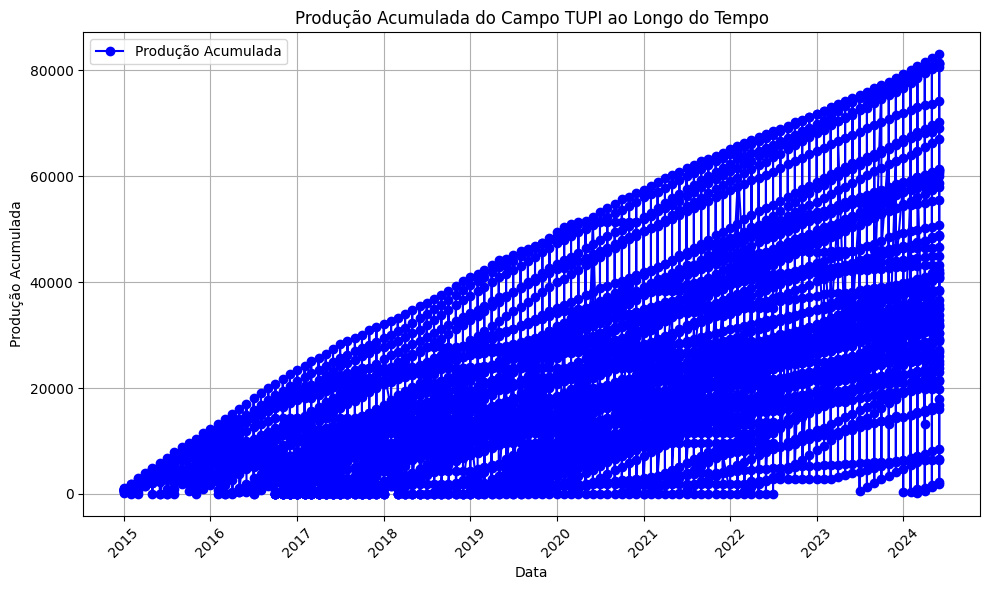

Data de corte para o treino: 2024-03-01 00:00:00


In [ ]:
# Filtrando os dados para o campo TUPI
df_tupi = df_prod[df_prod['campo'] == 'TUPI']

# Verificando os primeiros dados do campo TUPI
display(df_tupi)

# Plotando a produção acumulada ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(df_tupi['periodo'], df_tupi['producao_acumulada'], marker='o', color='b', label='Produção Acumulada')

# Adicionando título e rótulos
plt.title('Produção Acumulada do Campo TUPI ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Produção Acumulada')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.show()

# Verificando a data de corte
data_corte = df_tupi['periodo'].max() - pd.DateOffset(months=3)
print(f'Data de corte para o treino: {data_corte}')

# Verificando se o valor de 2024 está antes ou depois da data de corte
df_2024 = df_tupi[df_tupi['periodo'].dt.year == 2024]

,periodo,campo,producao_acumulada,oleo_kbd
12,2015-01-01,TUPI,8.604215e+03,277.555322
26,2015-02-01,TUPI,1.608757e+04,267.262673
39,2015-03-01,TUPI,2.500400e+04,288.070143
55,2015-04-01,TUPI,3.263363e+04,307.597181
72,2015-05-01,TUPI,4.189024e+04,298.600157
...,...,...,...,...
2639,2024-02-01,TUPI,2.367440e+06,744.677291
2671,2024-03-01,TUPI,2.422633e+06,787.704040
2703,2024-04-01,TUPI,2.399344e+06,722.729380
2735,2024-05-01,TUPI,2.461982e+06,755.464600


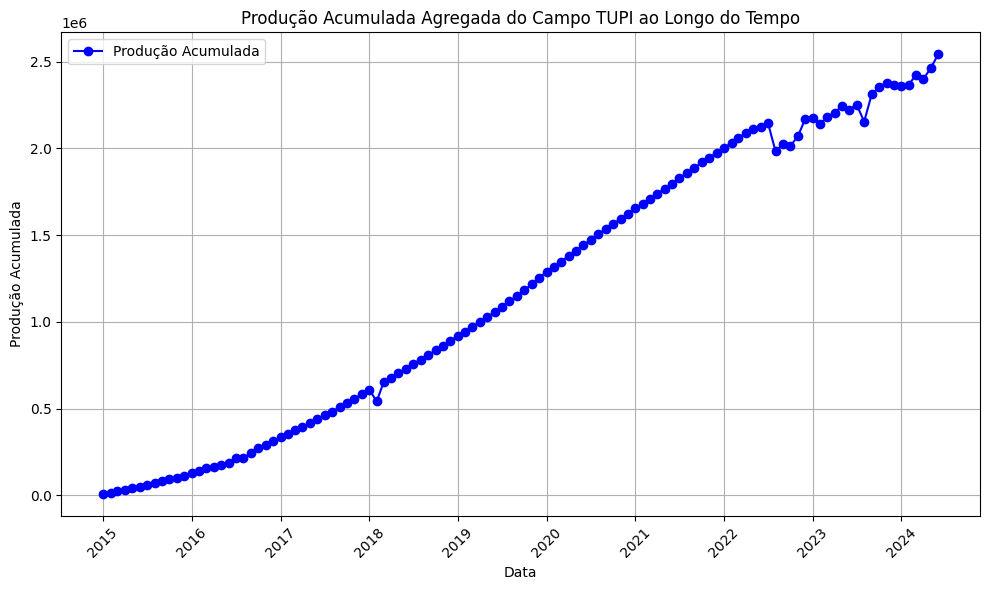

Mean Squared Error: 1536474544068.125
Produção prevista para o próximo mês: -768909.3893873083


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Agregar os dados por 'periodo' e 'campo', somando as colunas relevantes
df_agregado = df_prod.groupby(['periodo', 'campo'], as_index=False).agg({
    'producao_acumulada': 'sum',  # Somar a produção acumulada
    'oleo_kbd': 'sum'             # Somar a produção de óleo
})

# Filtrar os dados para o campo de interesse (TUPI)
campo_especifico = 'TUPI'
df_tupi_agregado = df_agregado[df_agregado['campo'] == campo_especifico]

# Visualizando os dados agregados do campo TUPI
display(df_tupi_agregado)

# Plotando a produção acumulada agregada ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(df_tupi_agregado['periodo'], df_tupi_agregado['producao_acumulada'], marker='o', color='b', label='Produção Acumulada')

# Adicionando título e rótulos
plt.title('Produção Acumulada Agregada do Campo TUPI ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Produção Acumulada')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.show()

# Definindo features e target
features = ['oleo_kbd']
target = 'producao_acumulada'

# Dividir os dados em treino e validação, garantindo que a sequência temporal seja mantida
X = df_tupi_agregado[features]
y = df_tupi_agregado[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)  # Não embaralhar para manter a sequência temporal

# Treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Prever a produção no conjunto de validação
y_pred = model.predict(X_val)

# Avaliar o modelo
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')

# Exemplo de previsão para o próximo mês (ajustando o valor de 'oleo_kbd')
novo_mes = {'oleo_kbd': 0.85}  # Aqui você ajusta o valor de 'oleo_kbd' para o próximo mês
X_novo_mes = pd.DataFrame([novo_mes])

# Prever a produção acumulada para o próximo mês
producao_prevista = model.predict(X_novo_mes)
print(f'Produção prevista para o próximo mês: {producao_prevista[0]}')
